In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import os

Using TensorFlow backend.


In [2]:
from sklearn.datasets import load_files
import numpy as np

train_dir = r'C:\Users\deVam\fruits-360\Training'
test_dir = r'C:\Users\deVam\fruits-360\Test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)
print('Loading complete!')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

Loading complete!
Training set size :  67692
Testing set size :  22688


In [3]:
no_of_classes = len(np.unique(y_train))
no_of_classes

131

In [4]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [5]:
from sklearn.model_selection import  train_test_split
x_test,x_valid,y_test,y_valid=train_test_split(x_test,y_test,test_size=0.2,random_state=42)

In [6]:
x_valid.shape, y_valid.shape

((4538,), (4538, 131))

In [7]:
x_test.shape,y_test.shape

((18150,), (18150, 131))

In [8]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_valid))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

print('1st training image shape ',x_train[0].shape)

Training set shape :  (67692, 100, 100, 3)
Validation set shape :  (4538, 100, 100, 3)
Test set shape :  (18150, 100, 100, 3)
1st training image shape  (100, 100, 3)


In [9]:
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Dense, Flatten, Dropout,Activation,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3),input_shape=(100,100,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32,kernel_size = (3,3),activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32,kernel_size = (3,3),activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(131,activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 16)      64        
_________________________________________________________________
average_pooling2d_1 (Average (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)       

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:


learned_weights = ModelCheckpoint(filepath = 'fruits_360_weights.hdf5', verbose = 1, save_best_only = True)

history = model.fit(x_train,y_train,
        batch_size = 32,
        epochs=30,
        validation_data=(x_valid, y_valid),
        callbacks = [learned_weights],
        verbose=2, shuffle=True)

In [12]:
model.load_weights('fruits_360_weights.hdf5')

In [13]:
accuracy = model.evaluate(x_test, y_test, verbose=0)

In [14]:
print(accuracy)

[0.16175491615858167, 0.9817630648612976]


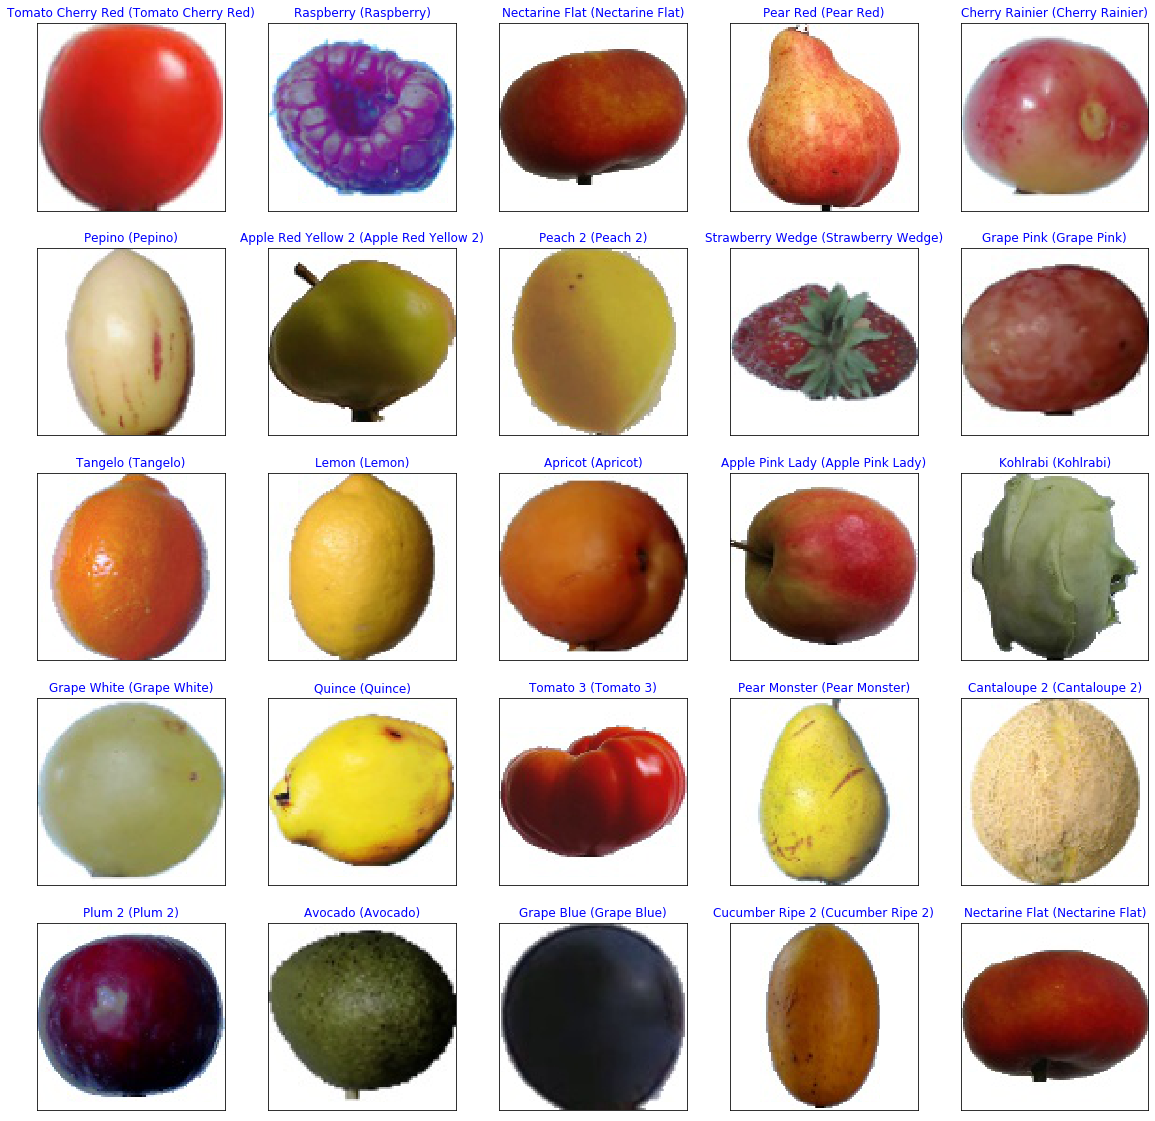

In [15]:
y_pred = model.predict(x_test)

fig = plt.figure(figsize=(20, 20))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=25, replace=False)):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "black"))